### Prediction Examples with Julia GLM





##### Logistic Regression 

Data comes from 

[https://github.com/selva86/datasets/blob/master/Churn_Modelling.csv]

and it is stored locally as `/hm2/Data/ML_Data/LogRegData/Churn_Modelling.csv`

The shape of the data is `[10000,14]`. The first row contains the names of the columns. The names are:

`RowNumber	CustomerId	Surname	CreditScore	Geography	Gender	Age	Tenure	Balance	NumOfProducts	HasCrCard	IsActiveMember	EstimatedSalary	Exited
`

The numerical columns are `[1,2,4,7,8,9,10,11,12,13,14]`



In [1]:
using CSV
using DataFrames
using Plots
using StatsPlots
using GLM
using Statistics
using Distributions
using Random
using MultivariateStats
using MLBase
using Makie, GLMakie

In [4]:

"""
        function SplitTrainTestSets (df, split)

Receives two arguments:

1. df is the DataFrame obj that will be used to return two subsets.
2. split is a number 0.0 < split < 1.0 that will be used to extract the fraction of rows
   for the training and testing set. For example, when split=0.75, then 75% of the original
   df will be used for the training set and the rest for testing.     

CAVEAT: The extaction is NOT randomized. The train set is extracted from the first split % of the rows in df.      
"""

function SplitTrainTestSets( df, split )

    dfSize = size(df)
    nrows = dfSize[1]
    nrowsTrain = round(Int, (nrows*split))
    nrowsTest = round(Int, (nrows - nrowsTrain))
    dfTrain = df[1:nrowsTrain, :]
    dfTest = df[nrowsTrain+1 : nrows ,: ]

    return dfTrain, dfTest
end


SplitTrainTestSets (generic function with 1 method)

In [5]:
## Get the data and obtain information about the shape of the data, composition etc. 
## Good news: there are no missing variables in the dataset. 


df = DataFrame(CSV.File("/hm2/Data/ML_Data/LogRegData/Churn_Modelling.csv"))

@show(describe(df))
@show(names(df))

first(df,5)

describe(df) = 14×7 DataFrame
 Row │ variable         mean       min       median     max        nmissing  eltype
     │ Symbol           Union…     Any       Union…     Any        Int64     DataType
─────┼────────────────────────────────────────────────────────────────────────────────
   1 │ RowNumber        5000.5     1         5000.5     10000             0  Int64
   2 │ CustomerId       1.56909e7  15565701  1.56907e7  15815690          0  Int64
   3 │ Surname                     Abazu                Zuyeva            0  String31
   4 │ CreditScore      650.529    350       652.0      850               0  Int64
   5 │ Geography                   France               Spain             0  String7
   6 │ Gender                      Female               Male              0  String7
   7 │ Age              38.9218    18        37.0       92                0  Int64
   8 │ Tenure           5.0128     0         5.0        10                0  Int64
   9 │ Balance          76485.9    0.0    

Row,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
,Int64,Int64,String31,Int64,String7,String7,Int64,Int64,Float64,Int64,Int64,Int64,Float64,Int64
1,1,15634602,Hargrave,619,France,Female,42,2,0.0,1,1,1,1.01349e5,1
2,2,15647311,Hill,608,Spain,Female,41,1,83807.9,1,0,1,1.12543e5,0
3,3,15619304,Onio,502,France,Female,42,8,1.59661e5,3,1,0,1.13932e5,1
4,4,15701354,Boni,699,France,Female,39,1,0.0,2,0,0,93826.6,0
5,5,15737888,Mitchell,850,Spain,Female,43,2,1.25511e5,1,1,1,79084.1,0


#### Data Composition

The dependent variable (y) is the last column `exited` that contains binary values  `[0,1]` .  All the other columns could be predictors that could be included in the matrix X


In [6]:
# Count the classes in the target variable. Note that I had to be specific about using Pkg GLM to invoke GLM.countma() 
GLM.countmap(df.Exited)

Dict{Int64, Int64} with 2 entries:
  0 => 7963
  1 => 2037

The data is quite unbalanced. About `80%` is `0` and only about `20%` is `1`

#### One Hot Encoding

One hot encoding converts categorical variables into numbers that could be used in ML algorithms for prediction. The data set has 3 columns that need to be converted into numbers:  

+ The column `Surname` has 2932 unique (different) values. Therefore it is not a good idea to encode it.  

+ The column `Gender` has two categories:  Female with a count of 4543, and Male with a count of 5457. 

+ The column `Geography` has 3 categories: Germany with a count of 2509, Spain with a count of 2477, and France with a count of 5014.

The code in the next cell shows how to obtain the counts

In [7]:
@show(GLM.countmap(df.Surname))

@show(GLM.countmap(df.Gender))

@show(GLM.countmap(df.Geography))


GLM.countmap(df.Surname) = Dict{String31, Int64}("Reichard" => 1, "Mikkelsen" => 1, "Hingston" => 1, "Dobie" => 2, "Padilla" => 1, "Hardacre" => 1, "Tillman" => 1, "Lionel" => 1, "Bazarova" => 2, "Bromby" => 1, "Threatt" => 1, "Chiemeka" => 1, "Cyril" => 1, "Yost" => 1, "Roberts" => 7, "Dunn" => 5, "Mitchell" => 20, "Sun" => 21, "Royster" => 1, "Woolacott" => 1, "Ah Mouy" => 1, "Gresswell" => 1, "Collee" => 1, "Descoteaux" => 1, "Gallo" => 11, "Upjohn" => 1, "Furneaux" => 2, "Bustard" => 1, "Pike" => 1, "Aksyonov" => 2, "Ponomaryov" => 2, "Nuttall" => 1, "Kolesnikova" => 1, "Moen" => 1, "Khan" => 3, "Zotov" => 1, "Artemova" => 2, "Baker" => 6, "Muomelu" => 1, "Nielson" => 1, "Tudawali" => 1, "Gaffney" => 1, "Castro" => 2, "Page" => 8, "Board" => 2, "Shipp" => 1, "Mishin" => 2, "Asher" => 1, "Trujillo" => 2, "Buckner" => 1, "Bess" => 1, "Osorio" => 1, "Kenechi" => 1, "Calzada" => 1, "Liu" => 12, "Coffey" => 1, "McClemans" => 2, "Georg" => 1, "McCall" => 1, "Spitzer" => 1, "Keldie" => 1,

Dict{String7, Int64} with 3 entries:
  "Germany" => 2509
  "Spain"   => 2477
  "France"  => 5014

In [8]:
### Do One Hot Encoding for Gender. I will eventually write this as a general purpose function 

function OneHotEncoding()
    #replace!(dfd.Default, "Yes" => "1")
    #replace!(dfd.Default, "No"  => "0")
    #dfd[!, :Default] = parse.(Int,dfd[!, :Default])
end

## One Hot encoding for Gender
replace!(df.Gender, "Female" => "1")
replace!(df.Gender, "Male"  => "0")
df[!, :Gender] = parse.(Int,df[!, :Gender])

first(df, 5) # GLM.countmap(df.Gender))




Row,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
,Int64,Int64,String31,Int64,String7,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Float64,Int64
1,1,15634602,Hargrave,619,France,1,42,2,0.0,1,1,1,1.01349e5,1
2,2,15647311,Hill,608,Spain,1,41,1,83807.9,1,0,1,1.12543e5,0
3,3,15619304,Onio,502,France,1,42,8,1.59661e5,3,1,0,1.13932e5,1
4,4,15701354,Boni,699,France,1,39,1,0.0,2,0,0,93826.6,0
5,5,15737888,Mitchell,850,Spain,1,43,2,1.25511e5,1,1,1,79084.1,0


In [9]:
## One Hot encoding for Geography
replace!(df.Geography, "France"  => "2")
replace!(df.Geography, "Germany" => "1")
replace!(df.Geography, "Spain"   => "0")
df[!, :Geography] = parse.(Int,df[!, :Geography])

first(df, 5)


Row,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
,Int64,Int64,String31,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Float64,Int64
1,1,15634602,Hargrave,619,2,1,42,2,0.0,1,1,1,1.01349e5,1
2,2,15647311,Hill,608,0,1,41,1,83807.9,1,0,1,1.12543e5,0
3,3,15619304,Onio,502,2,1,42,8,1.59661e5,3,1,0,1.13932e5,1
4,4,15701354,Boni,699,2,1,39,1,0.0,2,0,0,93826.6,0
5,5,15737888,Mitchell,850,0,1,43,2,1.25511e5,1,1,1,79084.1,0


In [10]:
size(df)

nrows = size(df)
nr = nrows[1]
println(nr)

dftrn, dftst =  SplitTrainTestSets(df, 0.75)

trnsize = size(dftrn)
println("trnsize = ", trnsize)

tstsize = size(dftst)
println("tstsize = ", tstsize)


10000
trnsize = (7500, 14)
tstsize = (2500, 14)


##### Logistic Regression under GLM



In [11]:
fm = @formula(Exited ~ CreditScore + Age + Tenure + Balance + NumOfProducts + HasCrCard + IsActiveMember + EstimatedSalary + Gender + Geography)
logit = glm(fm, dftrn, Binomial(), ProbitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, ProbitLink}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Exited ~ 1 + CreditScore + Age + Tenure + Balance + NumOfProducts + HasCrCard + IsActiveMember + EstimatedSalary + Gender + Geography

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                        Coef.   Std. Error       z  Pr(>|z|)     Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)      -2.33965      0.161676     -14.47    <1e-46  -2.65653      -2.02277
CreditScore      -0.000380474  0.000182443   -2.09    0.0370  -0.000738057  -2.28916e-5
Age               0.0434103    0.00168574    25.75    <1e-99   0.0401063     0.0467143
Tenure           -0.00414454   0.00612916    -0.68    0.4989  -0.0161575     0.0078684
Bala

In [12]:
prediction = predict(logit,dftst)

2500-element Vector{Union{Missing, Float64}}:
 0.24282920749289783
 0.4108576031850188
 0.17036280693987388
 0.14277824140847778
 0.0642723574160984
 0.06694186860930716
 0.2614014504087737
 0.3364970073516833
 0.2772268138080075
 0.08108435894453762
 ⋮
 0.5720510929279513
 0.14231570880749872
 0.1364756572618095
 0.1233378365972034
 0.13516910456761305
 0.053330061229661316
 0.07437170670584559
 0.23583034780734857
 0.19206519978343828

The glm prediction returns the probability that Exited is of class = 1. The scores obtained by the predictor must be  classified as 0 or 1.
Generally, the threshold for classifying the probability is chosen as 0.5.

The next cell converts the predictions to classes i.e. 0 or 1. The probability score less than 0.5 would be treated as 0 and the probability score greater than 0.5 would be treated as 1.

In [13]:
# Convert probability score to class
prediction_class = [if x < 0.5 0 else 1 end for x in prediction];

prediction_df = DataFrame(y_actual = dftst.Exited, y_predicted = prediction_class, prob_predicted = prediction);
prediction_df.correctly_classified = prediction_df.y_actual .== prediction_df.y_predicted

2500-element BitVector:
 1
 1
 0
 1
 0
 1
 0
 0
 1
 1
 ⋮
 1
 1
 1
 1
 1
 1
 0
 0
 1

The accuracy of the model is the total number ofd classes predicted correctly. The cell belows shows that the accuracy of the Log Reg mode is 0.808.
NOT BAD 


In [14]:
accuracy = mean(prediction_df.correctly_classified)

0.808

### Confusion Matrix

#### REFERENCE

[https://docs.google.com/presentation/d/1zOikKpq_FGpoptS3rTKSr1s7ILBI_5Dgx0aloXe3j04/edit#slide=id.g2d5e85855c2_0_11]

A Confusion Matrix (CM) is a table often used to evaluate and visualize the performance of a classification model.

The name comes from the fact that a CM can help to visualize if a system is confusing (or not) two classes (i.e. mislabeling one as the other).

Wikipedia has a good page where the concept of CM is introduced:

[https://en.wikipedia.org/wiki/Confusion_matrix]

The text below was adapted from Wikipedia:

In ML and in statistical classification, a CM is a table for visualizing the performance of an algorithm.

Each row of the CM represents the instances in an actual class while each column represents the instances in a predicted class, or vice versa.

The diagonal of the CM represents all instances correctly predicted. 

It is a special kind of contingency table, with two dimensions ("actual" and "predicted"), and identical sets of "classes" in both dimensions (each combination of dimension and class is a variable in the contingency table).

When we deal with a two-class classification, there are 4 different possible outcomes

```
 Predicted class is true  positive [1,1] : TP: A positive class is correctly predicted.  
 Predicted class is false positive [1,0] : FN: A positive class is predicted as negative. 
 Predicted class is false negative [0,1] : FP: A negative class is predicted as positive. 
 Predicted class is true  negative [0,0] : TN: A negative class is predicted as negative. 
```

```
              | Prediction  | P  | N  |
 Condition    | Total=P+N   | PP | PN |
              | P           | TP | FN |
              | N           | FP | TN |

              | PP = [1,1]  | FN = [1,0] |
              | FP = [0,1]  | TN = [0,0] |

                P = TP + FN
                N = FP + TN
                T = P + N    (T => Total)
                C = TP + TN  (C => Correct ) 
                ACC = C /T   (ACC => Accuracy)       
```

##### Confusion Matrix Example (From Wikipedia)

Suppose we have 12 individuals, 8 with cancer and 4 cancer-free.

We can show the outcome of the test as


```
| Subject Number  | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 | 11 | 12 |
| Actual Class    | 1  | 1  | 1  | 1  | 1  | 1  | 1  | 1  | 0  | 0  | 0  | 0  |
| Predicted Class | 0  |  0 | 1  | 1  | 1  | 1  | 1  | 1  | 1  | 0  | 0  | 0  |
| Result          | FN | FN | TP | TP | TP | TP | TP | TP | FP | TN | TN | TN |

```
Therefore  

```
  P = TP + FN = 6 + 3 = 8
  N = FP + TN = 1 + 3 = 4

  C = TP + TN = 6 + 3 = 9

  Accuracy = C / T = 9/12 = 0.75


```

But it doesn’t work with class 0. Either change the class 0 to 2 or use a different function. Let’s use the roc function from the MLBase library. It provides positive, negative, true positive, true negative, false positive, and false negative values.

In [15]:
# confusion_matrix = confusmat(2,prediction_df.y_actual, prediction_df.y_predicted)
cm = MLBase.roc(prediction_df.y_actual, prediction_df.y_predicted)

#=  cm will hae the following fields"
ROCNums{Int64}
  p = 491
  n = 2009
  tp = 83
  tn = 1937
  fp = 72
  fn = 408
  println("cm.p = ", cm.p)
  =#
acc = (cm.tp + cm.tn)/ (cm.p + cm.n)
println("Accuracy according to confusion matrix = ", acc)



Accuracy according to confusion matrix = 0.808


#### ROC

#### REFERENCES

[https://docs.google.com/presentation/d/1zOikKpq_FGpoptS3rTKSr1s7ILBI_5Dgx0aloXe3j04/edit#slide=id.g2d5e85855c2_0_29]

[https://docs.google.com/presentation/d/1nrcj_vZ52r16klTf3uOLr_xF52WPxg3vx7r28KKguZI/edit#slide=id.g2d47e688664_0_20]


ROC stands for `Receiver Operating Characteristic Curve`.

ROC is another evaluation metric that helps to determine a model predictive power. The area under the ROC curve can be used to evaluate and visualize the efficacy of different models.

There are no "good functions" in any of the packages in Julia to display an ROC. Let's write one from scratch, in the cell below


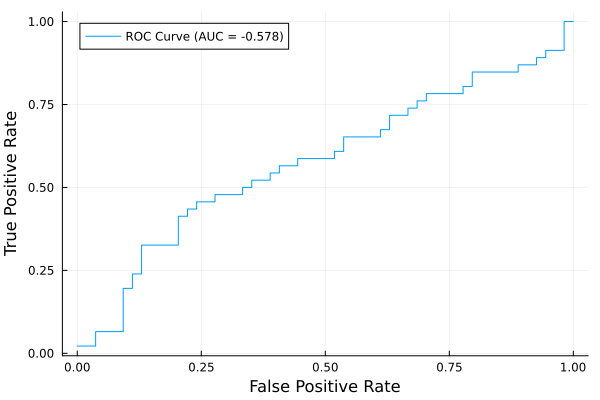

In [16]:

"""
    plot_roc_from_scratch(data::DataFrame, formula::FormulaTerm, target_variable::Symbol)

Plots the ROC curve from scratch for a logistic regression model fitted to the given data.

Args:
    data: DataFrame containing the data.
    formula: FormulaTerm specifying the model (e.g., `@formula(outcome ~ x1 + x2)`).
    target_variable: Symbol representing the name of the target variable column.

Returns:
    Nothing. Displays the ROC plot.
"""
function plot_roc_from_scratch(data::DataFrame, formula::FormulaTerm, target_variable::Symbol)
    # Fit GLM model
    model = glm(formula, data, Binomial(), LogitLink())

    # Predicted probabilities
    probs = predict(model, data)

    # Sort by predicted probabilities in descending order
    sorted_indices = sortperm(probs, rev=true)
    sorted_probs = probs[sorted_indices]
    sorted_labels = data[sorted_indices, target_variable]

    # Initialize variables
    tpr = Float64[]
    fpr = Float64[]
    tp = 0
    fp = 0
    p = sum(sorted_labels)  # Number of positives
    n = length(sorted_labels) - p  # Number of negatives

    # Calculate TPR and FPR at each threshold
    for i in 1:length(sorted_probs)
        if sorted_labels[i] == 1
            tp += 1
        else
            fp += 1
        end
        push!(tpr, tp / p)
        push!(fpr, fp / n)
    end

    # Calculate AUC using trapezoidal rule
    auc = sum((tpr[2:end] + tpr[1:end-1]) .* (fpr[1:end-1] - fpr[2:end])) / 2

    # Plot ROC curve
    Plots.plot(fpr, tpr, 
         label="ROC Curve (AUC = $(round(auc, digits=3)))", 
         xlabel="False Positive Rate", 
         ylabel="True Positive Rate")
end

# Example usage:
df1 = DataFrame(
    x1 = randn(100),
    x2 = randn(100),
    outcome = rand(100) .> 0.5
)
using Plots 
plot_roc_from_scratch(df1, @formula(outcome ~ x1 + x2), :outcome)

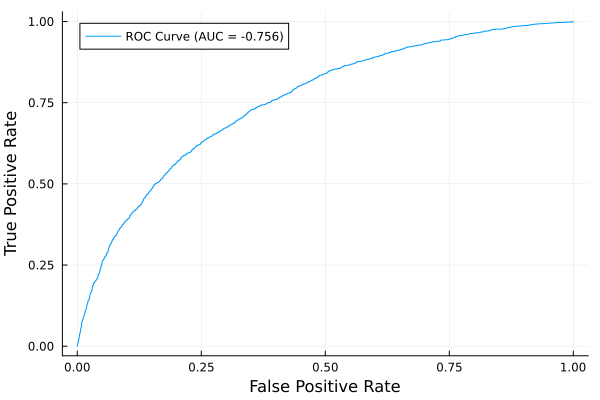

In [17]:
fm = @formula(Exited ~ CreditScore + Age + Tenure + Balance + NumOfProducts + HasCrCard + IsActiveMember + EstimatedSalary + Gender + Geography)
logit = glm(fm, dftrn, Binomial(), ProbitLink())

plot_roc_from_scratch(df, fm, :Exited)

# names(df)